### Model-Free Reinforcement Learning

Remember how in last Notebook we felt like cheating by using directions calculated from the map of the environment?? Well, model-free reinforcement learning deals with that. Model-free refers to the fact that algorithms unders this category do not need a model of the environment, also known as MDP, to calculate optimal policies.

In this notebook, we will look at what is perhaps the most popular model-free reinforcement learning algorithm, q-learning. Q-learning run without needing a map of the environment, it works by balancing the need for exploration with the need for exploiting previously explored knowledge. Let's take a look.

In [36]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tempfile
import pprint
import math
import json
import sys
import gym

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

#### Q-Learning

The function below, `action_selection` is an important aspect of reinforcement learning algorithms. The fact is, when you have possibly conflicting needs, explore vs exploit, you enter into a difficult situation, dilemma. The Exploration vs Exploitation Dilemma is at the core of reinforcement learning and it is good for you to think about it for a little while. How much do you need to explore an environment before you exploit it?

In the function below we use one of the many alternatives which is we explore a lot at the begining and decay the amount of exploration as we increase the number of episodes. Let's take a look at what the function looks like:

In [12]:
def action_selection(state, Q, episode, n_episodes):
    epsilon = max(0, episode/n_episodes*2)
    if np.random.random() < epsilon:
        action = np.random.randint(len(Q[0]))
    else:
        action = np.argmax(Q[state])
    return action, epsilon

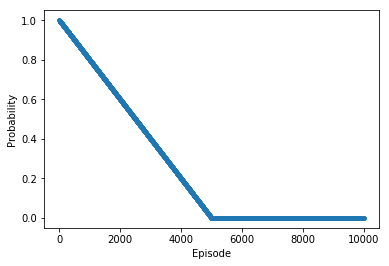

In [17]:
Q = [[0]]
n_episodes = 10000
epsilons = []
for episode in range(n_episodes//2, -n_episodes//2, -1):
    _, epsilon = action_selection(0, Q, episode, n_episodes)
    epsilons.append(epsilon)
plt.plot(np.arange(len(epsilons)), epsilons, '.')
plt.ylabel('Probability')
plt.xlabel('Episode')

See that? So, at episode 0 we have 100% change of acting randomly, all the way down to 0 when we stop exploring and instead always select the action that we think would maximizing the discounted future rewards. 

Again, this is a way of doing this, there are many and you surely should be thinking about better ways of doing so.

Next, let me show you what Q-Learning looks like:

In [19]:
def q_learning(env, alpha = 0.9, gamma = 0.9):
    nS = env.env.observation_space.n
    nA = env.env.action_space.n
    
    Q = np.random.random((nS, nA)) * 2.0
    n_episodes = 10000
    
    for episode in range(n_episodes//2, -n_episodes//2, -1):
        state = env.reset()
        done = False
        while not done:
            action, _ = action_selection(state, Q, episode, n_episodes)
            nstate, reward, done, info = env.step(action)
            Q[state][action] += alpha * (reward + gamma * Q[nstate].max() * (not done) - Q[state][action])
            state = nstate
    return Q

Nice, right? You just pass it an environment, nS and nA are the number of states and actions respectively. 

Q is a table of states as rows and actions as columns that will hold the expected reward the agent expects to get for taking action 'a' on state 's'. You can see how we initialize Q(s,a)'s to a random value, but also we multiply that by 2. You may ask, why is this? This is called "Optimism in the face of uncertainty" and it is a common reinforcement learning technique for encouraging agents to explore. Think about it on an intuitive level. If you think positively most of the time, if you receive a low balling job offer, you are going to pass on it and potentially get a better offer later. Worst case, you don't find any better offer and after 'adjusting' your estimates you will think an offer like the "low balling" one you got wasn't that bad after all. The same applies to reinforcement learning agent, cool right?

Then, I go on a loop for `n_episodes` using the `action_selection` function as described above. Don't pay too much attention to the range start and end, that is just the way I get the exploration strategy the way I showed. You should not like it, I don't like it. You will have a chance to make it better.

For now, let's unleash this agent and see how it does!!!

In [20]:
mdir = tempfile.mkdtemp()
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env, mdir, force=True)

Q = q_learning(env)

[2017-04-26 14:54:11,087] Making new env: FrozenLake-v0
[2017-04-26 14:54:11,092] Starting new video recorder writing to /tmp/tmpe11j2aj2/openaigym.video.0.93.video000000.json
[2017-04-26 14:54:11,094] Starting new video recorder writing to /tmp/tmpe11j2aj2/openaigym.video.0.93.video000001.json
[2017-04-26 14:54:11,098] Starting new video recorder writing to /tmp/tmpe11j2aj2/openaigym.video.0.93.video000008.json
[2017-04-26 14:54:11,104] Starting new video recorder writing to /tmp/tmpe11j2aj2/openaigym.video.0.93.video000027.json
[2017-04-26 14:54:11,116] Starting new video recorder writing to /tmp/tmpe11j2aj2/openaigym.video.0.93.video000064.json
[2017-04-26 14:54:11,130] Starting new video recorder writing to /tmp/tmpe11j2aj2/openaigym.video.0.93.video000125.json
[2017-04-26 14:54:11,154] Starting new video recorder writing to /tmp/tmpe11j2aj2/openaigym.video.0.93.video000216.json
[2017-04-26 14:54:11,183] Starting new video recorder writing to /tmp/tmpe11j2aj2/openaigym.video.0.93.v

Let's look at a couple of the episodes in more detail.

In [21]:
videos = np.array(env.videos)
n_videos = 5

idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
videos = videos[idxs,:]

In [22]:
urls = []
for i in range(n_videos):
    out = check_output(["asciinema", "upload", videos[i][0]])
    out = out.decode("utf-8").replace('\n', '').replace('\r', '')
    urls.append([out])
videos = np.concatenate((videos, urls), axis=1)

In [24]:
strm = ''
for video_path, meta_path, url in videos:

    with open(meta_path) as data_file:    
        meta = json.load(data_file)
    castid = url.split('/')[-1]
    html_tag = """
    <h2>{0}
    <script type="text/javascript" 
        src="https://asciinema.org/a/{1}.js" 
        id="asciicast-{1}" 
        async data-autoplay="true" data-size="big">
    </script>
    """
    strm += html_tag.format('Episode ' + str(meta['episode_id']),
                               castid)
HTML(data=strm)

Nice!!!

You can see the progress of this agent. From total caos completely sinking into holes, to sliding into the goal fairly consistently.

Let's inspect the Values and Policies.

In [25]:
V = np.max(Q, axis=1)
V

array([ 0.03843929,  0.00907311,  0.05889145,  0.01216185,  0.07912733,
        1.81991842,  0.01744396,  1.7286877 ,  0.09666762,  0.35824406,
        0.66550044,  1.76576476,  1.89998862,  0.71040231,  0.97740312,
        1.23591297])

In [27]:
pi = np.argmax(Q, axis=1)
pi

array([0, 3, 3, 3, 0, 1, 2, 3, 3, 1, 0, 0, 3, 2, 1, 1])

Fair enough, let's close this environment and you will have a chance to submit to your OpenAI account. After that, you will have a chance to modify the `action_selection` to try something different.

In [29]:
env.close()

In [11]:
gym.upload(mdir, api_key='<YOUR OPENAI API KEY>')

[2017-04-02 00:40:50,777] [FrozenLake-v0] Uploading 10000 episodes of training data
[2017-04-02 00:40:52,390] [FrozenLake-v0] Uploading videos of 19 training episodes (1810 bytes)
[2017-04-02 00:40:52,639] [FrozenLake-v0] Creating evaluation object from /tmp/tmpww4igizw with learning curve and training video
[2017-04-02 00:40:52,874] 
****************************************************
You successfully uploaded your evaluation on FrozenLake-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_hGg7u5NwS1a35elvMZC0Q

****************************************************


### Your turn

Maybe you want to try an exponential decay?? (http://www.miniwebtool.com/exponential-decay-calculator/)

P(t) = P0e-rt

where: 
* P(t) = the amount of some quantity at time t 
* P0 = initial amount at time t = 0 
* r = the decay rate 
* t = time (number of periods)

In [73]:
def action_selection(state, Q, episode, n_episodes, decay=0.0006, initial=1.00):
    epsilon = initial * math.exp(-decay*episode)
    if np.random.random() < epsilon:
        action = np.random.randint(len(Q[0]))
    else:
        action = np.argmax(Q[state])
    return action, epsilon

Use the following code to test your new exploration strategy:

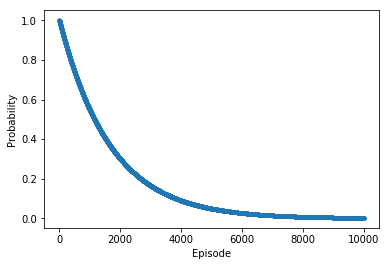

In [74]:
Q = [[0]]
n_episodes = 10000
epsilons = []
for episode in range(n_episodes):
    _, epsilon = action_selection(0, Q, episode, n_episodes)
    epsilons.append(epsilon)
plt.plot(np.arange(len(epsilons)), epsilons, '.')
plt.ylabel('Probability')
plt.xlabel('Episode')

Let's redefine the `q_learning` function we had above and run it against the environment again.

In [75]:
def q_learning(env, alpha = 0.9, gamma = 0.9):
    nS = env.env.observation_space.n
    nA = env.env.action_space.n
    
    Q = np.random.random((nS, nA)) * 2.0
    n_episodes = 10000
    
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        while not done:
            action, _ = action_selection(state, Q, episode, n_episodes)
            nstate, reward, done, info = env.step(action)
            Q[state][action] += alpha * (reward + gamma * Q[nstate].max() * (not done) - Q[state][action])
            state = nstate
    return Q

In [72]:
mdir = tempfile.mkdtemp()
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env, mdir, force=True)

Q = q_learning(env)

[2017-04-26 15:09:54,069] Making new env: FrozenLake-v0
[2017-04-26 15:09:54,081] Starting new video recorder writing to /tmp/tmpwmjvyk26/openaigym.video.2.93.video000000.json
[2017-04-26 15:09:54,086] Starting new video recorder writing to /tmp/tmpwmjvyk26/openaigym.video.2.93.video000001.json
[2017-04-26 15:09:54,093] Starting new video recorder writing to /tmp/tmpwmjvyk26/openaigym.video.2.93.video000008.json
[2017-04-26 15:09:54,104] Starting new video recorder writing to /tmp/tmpwmjvyk26/openaigym.video.2.93.video000027.json
[2017-04-26 15:09:54,121] Starting new video recorder writing to /tmp/tmpwmjvyk26/openaigym.video.2.93.video000064.json
[2017-04-26 15:09:54,135] Starting new video recorder writing to /tmp/tmpwmjvyk26/openaigym.video.2.93.video000125.json
[2017-04-26 15:09:54,155] Starting new video recorder writing to /tmp/tmpwmjvyk26/openaigym.video.2.93.video000216.json
[2017-04-26 15:09:54,190] Starting new video recorder writing to /tmp/tmpwmjvyk26/openaigym.video.2.93.v

Curious to see how the new agent did?? Let's check it out!

In [76]:
videos = np.array(env.videos)
n_videos = 5

idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
videos = videos[idxs,:]

In [77]:
urls = []
for i in range(n_videos):
    out = check_output(["asciinema", "upload", videos[i][0]])
    out = out.decode("utf-8").replace('\n', '').replace('\r', '')
    urls.append([out])
videos = np.concatenate((videos, urls), axis=1)

In [78]:
strm = ''
for video_path, meta_path, url in videos:

    with open(meta_path) as data_file:    
        meta = json.load(data_file)
    castid = url.split('/')[-1]
    html_tag = """
    <h2>{0}
    <script type="text/javascript" 
        src="https://asciinema.org/a/{1}.js" 
        id="asciicast-{1}" 
        async data-autoplay="true" data-size="big">
    </script>
    """
    strm += html_tag.format('Episode ' + str(meta['episode_id']),
                               castid)
HTML(data=strm)

Did it do good??? This isn't an easy thing, take your time. Be sure to look into the Notebook solution if you want an idea.

For now, let's take a look at the value function and policy the agent came up with.

In [79]:
V = np.max(Q, axis=1)
V

array([0])

In [80]:
pi = np.argmax(Q, axis=1)
pi

array([0])

Good??? Nice!

Let's wrap-up!

In [81]:
env.close()

[2017-04-26 15:13:34,165] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/tmpwmjvyk26')


In [ ]:
gym.upload(mdir, api_key='<YOUR OPENAI API KEY>')

So, this notebook shows you how agents do when they don't have a definition of the environment. They will be interacting with it, just like you and I would. 

Now, we are one step closer, but you probably are wondering, if this is 'model-free' reinforcement learning, is 'model-based' reinforcement learning the algorithms we learned before? Well, not really. Model-based reinforcement learning algorithms use of the experience, perhaps in addition to what model-free algorithms do, to come up models of the environment. This helps for many things, the one worth highlighting are, algorithms can require less computation, and more importantly less exploration. This is vital when experience is expensive to collect. Think a robot learning to walk. What's the price of a robot collapsing into the floor?

Additionally, you should have a little thing bothering you. Isn't it disappointing to be dealing with discrete states and actions?? Who are we kidding? A robot doesn't know to go to state 2?!!? 

So, yeah, we have been working with discrete states and actions. That's just not the way the world works. Let's step it a bit up. In the following lessons we'll discuss what to do when states and later actions are continuous and perhaps too large to even store on a table the way Q does it in q-learning. You ready? Let's go.